# DATA EXPLORATION

Import libraries

In [42]:
# For General Data Wrangling and Calculations
import pandas as pd
import numpy as np

# For NLP
import nltk

# For stop word filtering
#nltk.download("stopwords")
from nltk.corpus import stopwords

# For tokenizing
from nltk.tokenize import RegexpTokenizer, word_tokenize
#nltk.download('punkt_tab')
#nltk.download('wordnet')

# For lemmatizing
from nltk.stem import WordNetLemmatizer

# For TF-IDF transformation
from sklearn.feature_extraction.text import TfidfVectorizer

# For Word Embedding
import sent2vec

# For plotting
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


Load input files

In [6]:
# Train data path
train_df = "../data/medical_tc_train.csv"
# Test data path
test_df = "../data/medical_tc_test.csv"
# Labels path
labels_df = "../data/medical_tc_labels.csv"

# Open train data
train_df = pd.read_csv(train_df)
test_df = pd.read_csv(test_df)
labels_df = pd.read_csv(labels_df)

# Visualize top 10 rows
print(f"Training set (length: {len(train_df)}):\n", train_df.head(10))
print(f"Test set (length: {len(test_df)}):\n", test_df.head(10))
print(f"Labels (length: {len(labels_df)}):\n", labels_df.head(10))

Training set (length: 11550):
    condition_label                                   medical_abstract
0                5  Tissue changes around loose prostheses. A cani...
1                1  Neuropeptide Y and neuron-specific enolase lev...
2                2  Sexually transmitted diseases of the colon, re...
3                1  Lipolytic factors associated with murine and h...
4                3  Does carotid restenosis predict an increased r...
5                3  The shoulder in multiple epiphyseal dysplasia....
6                2  The management of postoperative chylous ascite...
7                4  Pharmacomechanical thrombolysis and angioplast...
8                5  Color Doppler diagnosis of mechanical prosthet...
9                5  Noninvasive diagnosis of right-sided extracard...
Test set (length: 2888):
    condition_label                                   medical_abstract
0                3  Obstructive sleep apnea following topical orop...
1                5  Neutrophil fu

Add labels to train data for posterior visualization

In [7]:
train_df = pd.merge(train_df,labels_df, how = "left", on = "condition_label")

# Visualize top rows
train_df.head()

,condition_label,medical_abstract,condition_name
0,5,Tissue changes around loose prostheses. A cani...,general pathological conditions
1,1,Neuropeptide Y and neuron-specific enolase lev...,neoplasms
2,2,"Sexually transmitted diseases of the colon, re...",digestive system diseases
3,1,Lipolytic factors associated with murine and h...,neoplasms
4,3,Does carotid restenosis predict an increased r...,nervous system diseases


## 1. Text Processing
### 1.1. Lower text and remove stopwords / punctuation
Stop words are frequently found in all kind of texts since thay contribute to the sentence structure and meaning. However, they should be removed (depending on the analysis) to reduce the noise they might produce. Also, after removing them we will have a reduced text amount to process (data size reduction) and an improved performance. Besides, to have a more homogenous text it is necessary to lower all the text and remove punctuations.

In [8]:
# Define stop words
stop_words = set(stopwords.words("english"))

Define function to remove stop words from data

In [9]:
def remove_stopwords_punctutation(data_df):

    # Define tokenizer
    tokenizer = RegexpTokenizer(r"\w+")
    
    # Initialize loop to iterate through
    for i, row in data_df.iterrows():
    
        # Get cell
        text = row["medical_abstract"]
    
        # Check if the cell contains text
        if isinstance(text, str):
        
            # Lower and tokenize text
            tokens = tokenizer.tokenize(text.lower())
        
            # Remove stop words
            tokens_clean = [token for token in tokens if token not in stop_words]
        
            # Detokenize text
            cleaned_sentence = " ".join(tokens_clean)

            # Save processed text
            data_df.loc[i, "medical_abstract"] = cleaned_sentence

    # Return cleaned text
    return data_df

Clean text

In [10]:
# Train data
train_clean_df = remove_stopwords_punctutation(train_df)
# Test data
test_clean_df = remove_stopwords_punctutation(test_df.drop(columns = ["condition_label"]))
# We drop the condition_label to not have it into account during the data exploration of data to be classified.

# Visualize top rows
#train_clean_df.head()
test_clean_df.head()

,medical_abstract
0,obstructive sleep apnea following topical orop...
1,neutrophil function pyogenic infections bone m...
2,phase ii study combined methotrexate teniposid...
3,flow cytometric dna analysis parathyroid tumor...
4,paraneoplastic vasculitic neuropathy treatable...


### 1.2. Lemmatize
Lemmatizing reduce the words to their core meaning. For example, for words such as "do", "doing" and "done", lemmatizing will substitute them by "do", their core word. This process again reduces the amount of text to process (amount of total unique words), making the procesing more efficient.

Define function to lemmatize data

In [11]:
def lemmatize_data(data_df):

    # Define lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Define counter to count sentences that do not change with lemmatization
    counter = 0
    
    # Initialize loop to iterate through
    for i, row in data_df.iterrows():
    
        # Get cell
        text = row["medical_abstract"]
    
        # Check if the cell contains text
        if isinstance(text, str):
        
            # Lower and tokenize text
            tokens = word_tokenize(text)
        
            # Lemmatize
            lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        
            # Detokenize text
            lemma_sentence = " ".join(lemmas)

            # Save processed text
            data_df.loc[i, "medical_abstract"] = lemma_sentence

            # Check if sentences are the same
            if text == lemma_sentence:
                counter += 1

    # Report the amount of lemmatized sentences
    if counter == len(data_df):
        print(f"All medical abstracts' text have remained the same after lemmatization: {counter}/{len(data_df)}")

        # Return cleaned text
        return data_df
    
    elif counter < len(data_df):
        print(f"Some sentences have been lemmatized: {counter}/{len(data_df)}")

        # Return cleaned text
        return data_df

    else:
        raise Exception(f"Something went wrong: {counter}/{len(data_df)}")

Lemmatize text

In [12]:
# Train data
train_lemma_df = lemmatize_data(train_clean_df)
# Test data
test_lemma_df = lemmatize_data(test_clean_df)

# Visualize top rows
#train_lemma_df.head()
test_lemma_df.head()

Some sentences have been lemmatized: 106/11550
Some sentences have been lemmatized: 24/2888


,medical_abstract
0,obstructive sleep apnea following topical orop...
1,neutrophil function pyogenic infection bone ma...
2,phase ii study combined methotrexate teniposid...
3,flow cytometric dna analysis parathyroid tumor...
4,paraneoplastic vasculitic neuropathy treatable...


### 1.3. Text Vectorization
Text vectorization is converting text into numeric data, by transforming the textual data into vectors.
#### 1.3.1. Term Frequency-Inverse Document Frequency (TF-IDF)
The TF-IDF technique measured the relevance of a term present in a document (medical abstract) within a larger corpus (the entire collection). To calculate the TF-IDF the following formula was applied:
$$
\text{TF-IDF} = \frac{n}{d} \times \log_{10} \frac{N}{n}
$$
Where:
- \(n\): The frequency of the term in the document.
- \(d\): The total number of terms in the document.
- \(N\): The total number of documents in the corpus.
- \(n_t\): The number of documents that contain the term.
- (TF): Term Frequency, calculated as:
   $$\frac{n}{d}$$
- (IDF): Inverse Document Frequency, calculated as:
  $$\log_{10} \frac{N}{n_t}$$

Define function for performing the TF-IDF tranformation

In [13]:
def tfidf_transformation(data_df):

    # Define corpus
    corpus = data_df["medical_abstract"]

    # Define and instance of the TF-ID vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform corpus into a matrix containing TF-IDF
    matrix = vectorizer.fit_transform(corpus)

    # Return matrix
    return matrix

Transform text to vector using TF-IDF tranformation

In [14]:
# Training lemmatized data
train_raw_tdidf = tfidf_transformation(train_df)
# Testing lemmatized data
test_raw_tdidf = tfidf_transformation(test_df)

# Training lemmatized data
train_lem_tdidf = tfidf_transformation(train_lemma_df)
# Testing lemmatized data
test_lem_tdidf = tfidf_transformation(test_lemma_df)

### 1.3.2. Sentence Embedding using BioSentVec
Sentence embedding is a language modelling technique that converts sentences to vectors of real numbers. This technique represents a sentence in vector space with multiple dimensions. In this case, we will use a model called BioSentVec, which is a pre-trained embedding model for biomedical sentences. It was trained on PubMed and MIMIC-III texts.

Load model

In [15]:
# Define the model location
model_path = "../model/BioSentVec_PubMed_MIMICIII-bigram_d700.bin"
# Define the model instance
model = sent2vec.Sent2vecModel()

# Load model
try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


Define function to transform sentence to vector using BioSentVec model

In [25]:
def sentence_to_vector(data_df):
    
    # Initialize an empty list to store the sentence vectors
    vectors = []
    
    # Initialize loop to iterate through
    for i, row in data_df.iterrows():
    
        # Get cell
        text = row["medical_abstract"]
    
        # Check if the cell contains text
        if isinstance(text, str):

            # Retrieve vector from sentence
            sentence_vector = model.embed_sentence(text)

            # Append the vector to the list
            vectors.append(sentence_vector)

    # Return array with sentences' vectors
    return np.array(vectors)

Transform sentences to vectors using BioSentVec model

In [26]:
# Training lemmatized data
train_raw_vec = sentence_to_vector(train_df)
# Testing lemmatized data
test_raw_vec = sentence_to_vector(test_df)

# Training lemmatized data
train_lem_vec = sentence_to_vector(train_lemma_df)
# Testing lemmatized data
test_lem_vec = sentence_to_vector(test_lemma_df)

## 2. DATA VISUALIZATION
### 2.1. Distribution of number of characters in the text
We will explore the amount of characters are found in each medical abstract pre- and post-processing of text.
#### 2.1.1. Pre-Processing
Define Function to count characters

In [34]:
def count_characters(data_df, dataset_type = "train"):

    # Initialize an dictionary to store the character length of sentences
    length_dict = {
        "neoplasms": [],
        "digestive system diseases": [],
        "nervous system diseases": [],
        "cardiovascular diseases": [],
        "general pathological conditions":[],
        "total": []
    }
    
    # Initialize loop to iterate through
    for i, row in data_df.iterrows():
    
        # Get cell
        text = row["medical_abstract"]

        # Check dataset type
        if dataset_type == "train":
            # Get condition
            condition = row["condition_name"]
        
        # Check if the cell contains text
        if isinstance(text, str):

            # Get the text length
            text_length = len(text)

            # Add to the Total list in the dictionary
            length_dict["total"].append(text_length)

            # Check dataset type
            if dataset_type == "train":
                # Add to the condition list in the dictionary
                length_dict[condition].append(text_length)

    # Return results
    return length_dict if dataset_type == "train" else length_dict["total"]


Define function to plot

In [44]:
def plot_histogram(data_dict, data_type):
    """
    Plot histograms of text lengths.

    Parameters:
        data_dict: dict or list
            If data_type is 'train', this should be a dictionary with conditions and total lengths.
            If data_type is 'test', this should be a list of lengths.
        data_type: str
            Either 'train' or 'test'.
    """
    if data_type == 'train':
        # Parameters
        bins = 10  # Number of bins
        alpha_total = 0.3  # Transparency for total distribution
        colors = ['blue', 'green', 'orange']  # Colors for conditions

        # Extract the total data and conditions
        total_data = data_dict['total']
        conditions = {key: value for key, value in data_dict.items() if key != 'total'}

        # Plot the total distribution
        plt.hist(
            total_data, bins=bins, color='grey', alpha=alpha_total, label='Total', edgecolor='none'
        )

        # Plot each condition's distribution
        for idx, (condition, lengths) in enumerate(conditions.items()):
            plt.hist(
                lengths, bins=bins, alpha=0.7, color=colors[idx % len(colors)], label=condition, edgecolor='none'
            )

        # Add labels, legend, and title
        plt.xlabel('Length')
        plt.ylabel('Frequency')
        plt.title('Histogram of Text Lengths by Condition')
        plt.legend()

    elif data_type == 'test':
        # Parameters
        bins = 20  # Number of bins
        alpha = 0.7  # Transparency for the test data

        # Plot the histogram for test data
        plt.hist(
            data_dict, bins=bins, color='blue', alpha=alpha, label='Test Data', edgecolor='none'
        )

        # Add labels and title
        plt.xlabel('Length')
        plt.ylabel('Frequency')
        plt.title('Histogram of Text Lengths (Test Data)')
        plt.legend()

    else:
        raise ValueError("Invalid data_type. Must be 'train' or 'test'.")

    # Show plot
    plt.show()

Get character length distribution of datasets

In [35]:
# Training lemmatized data
train_raw_len = count_characters(train_df)
# Testing lemmatized data
test_raw_len = count_characters(test_df, "test")

# Training lemmatized data
train_lem_len = count_characters(train_lemma_df)
# Testing lemmatized data
test_lem_len = count_characters(test_lemma_df, "test")

Plot character length distributions

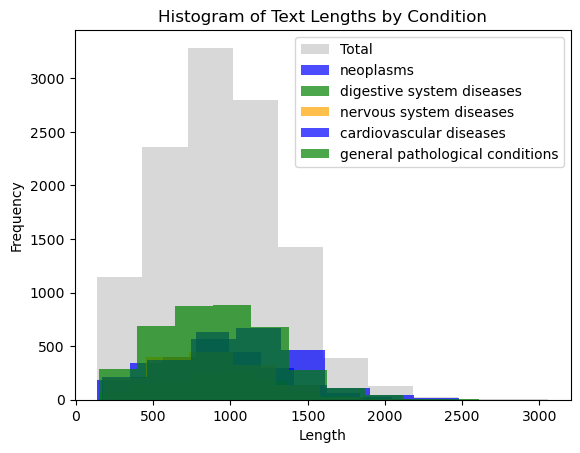

In [45]:
# For Raw Training data
plot_histogram(train_raw_len, "train")

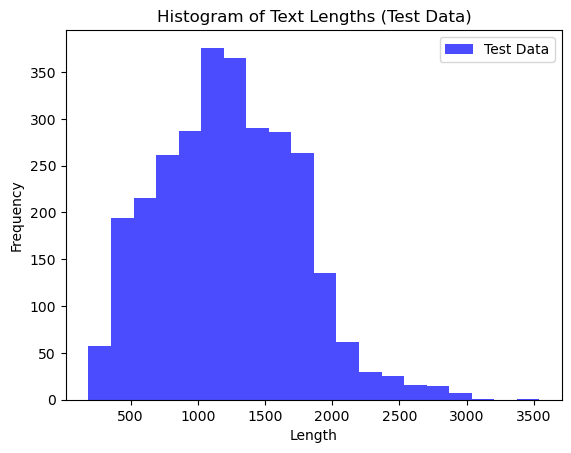

In [48]:
# For Raw Testing data
plot_histogram(test_raw_len, "test")